In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import gensim
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
SEQUENCE_LENGTH = 300
EPOCHS = 6
BATCH_SIZE = 1024
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
training_data = '/content/drive/MyDrive/Colab Notebooks/Colab Data/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(training_data, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
print('Dataset size:', len(df))
df.head(5)

Dataset size: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
  return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 504 ms, sys: 5.47 ms, total: 510 ms
Wall time: 516 ms


Text(0.5, 1.0, 'Label Distribution')

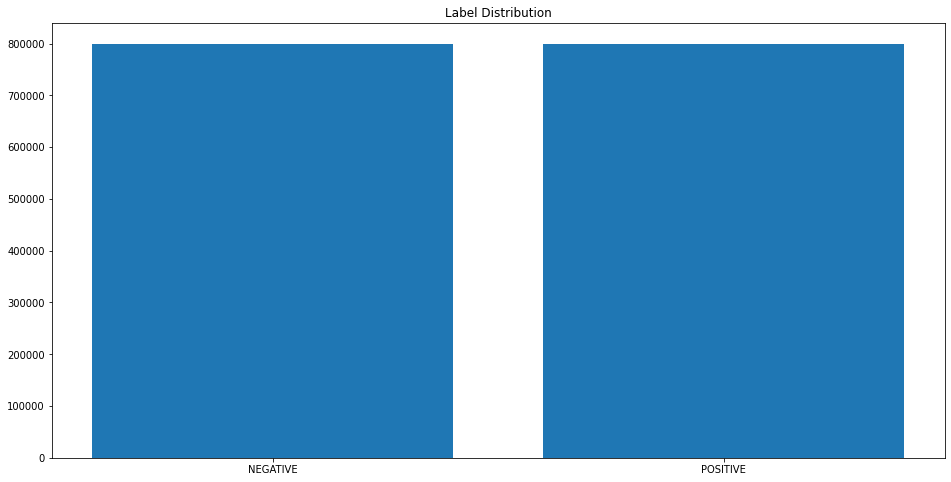

In [9]:
target_cnt = Counter(df.target)
plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Label Distribution")

In [10]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    return text

In [11]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 16.9 s, sys: 415 ms, total: 17.3 s
Wall time: 22.9 s


In [12]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [13]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 6.22 s, sys: 1.17 s, total: 7.4 s
Wall time: 7.46 s


In [14]:
w2v_model = gensim.models.word2vec.Word2Vec(size=120, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [15]:
w2v_model.build_vocab(documents)

2022-06-28 16:34:16,513 : INFO : collecting all words and their counts
2022-06-28 16:34:16,518 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-28 16:34:16,605 : INFO : PROGRESS: at sentence #10000, processed 132353 words, keeping 14152 word types
2022-06-28 16:34:16,676 : INFO : PROGRESS: at sentence #20000, processed 263840 words, keeping 21737 word types
2022-06-28 16:34:16,780 : INFO : PROGRESS: at sentence #30000, processed 394116 words, keeping 27691 word types
2022-06-28 16:34:16,860 : INFO : PROGRESS: at sentence #40000, processed 526961 words, keeping 32914 word types
2022-06-28 16:34:16,940 : INFO : PROGRESS: at sentence #50000, processed 657960 words, keeping 37737 word types
2022-06-28 16:34:17,020 : INFO : PROGRESS: at sentence #60000, processed 789020 words, keeping 42348 word types
2022-06-28 16:34:17,104 : INFO : PROGRESS: at sentence #70000, processed 920177 words, keeping 46609 word types
2022-06-28 16:34:17,185 : INFO : PROGRESS: at 

In [16]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30520


In [17]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-06-28 16:34:42,679 : INFO : training model with 8 workers on 30520 vocabulary and 120 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-06-28 16:34:43,830 : INFO : EPOCH 1 - PROGRESS: at 1.78% examples, 215681 words/s, in_qsize 15, out_qsize 1
2022-06-28 16:34:44,837 : INFO : EPOCH 1 - PROGRESS: at 4.15% examples, 256136 words/s, in_qsize 15, out_qsize 0
2022-06-28 16:34:45,867 : INFO : EPOCH 1 - PROGRESS: at 6.23% examples, 257369 words/s, in_qsize 15, out_qsize 0
2022-06-28 16:34:46,876 : INFO : EPOCH 1 - PROGRESS: at 8.54% examples, 264388 words/s, in_qsize 16, out_qsize 1
2022-06-28 16:34:47,886 : INFO : EPOCH 1 - PROGRESS: at 10.97% examples, 272486 words/s, in_qsize 15, out_qsize 0
2022-06-28 16:34:48,952 : INFO : EPOCH 1 - PROGRESS: at 13.35% examples, 274193 words/s, in_qsize 15, out_qsize 0
2022-06-28 16:34:50,010 : INFO : EPOCH 1 - PROGRESS: at 15.71% examples, 275687 words/s, in_qsize 14, out_qsize 1
2022-06-28 16:34:51,061 : INFO : EPOCH 1 - PROGRESS: at 

CPU times: user 36min 32s, sys: 14.1 s, total: 36min 47s
Wall time: 20min 1s


(406707580, 540038688)

In [18]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290572
CPU times: user 27.9 s, sys: 219 ms, total: 28.1 s
Wall time: 28.1 s


In [19]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=120)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=120)

CPU times: user 34.4 s, sys: 892 ms, total: 35.3 s
Wall time: 35.3 s


In [20]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())
y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [22]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("---------")
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 120)
y_train (1280000, 1)
---------
x_test (320000, 120)
y_test (320000, 1)


In [23]:
embedding_matrix = np.zeros((vocab_size, 120))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290572, 120)


In [24]:
embedding_layer = Embedding(vocab_size, 120, weights=[embedding_matrix], input_length=120, trainable=False)

In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 120)          34868640  
                                                                 
 dropout (Dropout)           (None, 120, 120)          0         
                                                                 
 lstm (LSTM)                 (None, 50)                34200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34,902,891
Trainable params: 34,251
Non-trainable params: 34,868,640
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [27]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/6
1125/1125 [==============================] - 2299s 2s/step - loss: 0.5752 - accuracy: 0.6952 - val_loss: 0.4899 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 2/6
1125/1125 [==============================] - 2330s 2s/step - loss: 0.5279 - accuracy: 0.7360 - val_loss: 0.4666 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 3/6
1125/1125 [==============================] - 2314s 2s/step - loss: 0.5161 - accuracy: 0.7437 - val_loss: 0.4649 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 4/6
1125/1125 [==============================] - 2155s 2s/step - loss: 0.5087 - accuracy: 0.7499 - val_loss: 0.4606 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 5/6
1125/1125 [==============================] - 2118s 2s/step - loss: 0.5049 - accuracy: 0.7520 - val_loss: 0.4590 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 6/6
 152/1125 [===>..........................] - ETA: 29:56 - loss: 0.5027 - accuracy: 0.7529

In [29]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 110s 349ms/step - loss: 0.4490 - accuracy: 0.7898

ACCURACY: 0.7897593975067139
LOSS: 0.4490077495574951
CPU times: user 3min 9s, sys: 12.8 s, total: 3min 22s
Wall time: 1min 49s


In [33]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [34]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=120)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

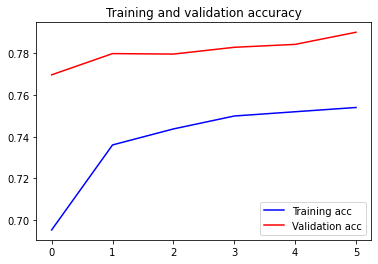

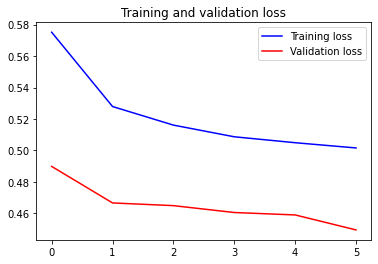

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [35]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 121s 3s/step
CPU times: user 3min 17s, sys: 9.57 s, total: 3min 26s
Wall time: 2min 1s


In [38]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

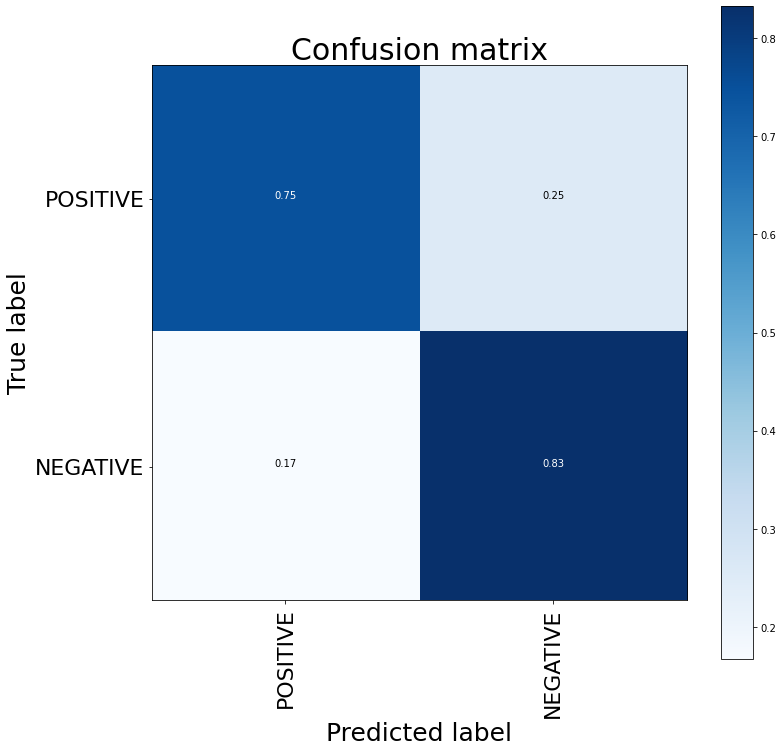

CPU times: user 2.48 s, sys: 23.1 ms, total: 2.5 s
Wall time: 4.32 s


In [39]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [36]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.82      0.75      0.78    159494
    POSITIVE       0.77      0.83      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [37]:
accuracy_score(y_test_1d, y_pred_1d)

0.789759375

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-06-26 17:06:48,274 : INFO : saving Word2Vec object under model.w2v, separately None
2022-06-26 17:06:48,290 : INFO : not storing attribute vectors_norm
2022-06-26 17:06:48,301 : INFO : not storing attribute cum_table
2022-06-26 17:06:49,220 : INFO : saved model.w2v


In [ ]:
model.save_weights('model_weights.h5')

In [ ]:
source_path = '/content/model.h5'
destination_path = '/content/drive/MyDrive/model_new.h5'
os.replace(source_path, destination_path)